# DeepDR Plus

This example demostrate how DeepDR Plus model was trained and interprated. In this example, Mnist dataset is used just to demostrate how to use DeepDR Plus model works. We define the digits 0 to 9 as the time-to-event, and we define the target event will happed at digit 0. We randomly select two time points in the following 10 years as the follow-up visit to simulate the interval censoring and right censoring.

### Import the libraries

In [1]:
import pickle
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

from survivalreg.dataset import SurvivalFuncEstimateDataset, Sample
from survivalreg.trainer import Trainer
from functools import cached_property
import numpy as np
import torch
from torch import nn
from torchvision.datasets.mnist import MNIST
import random
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.signal import convolve2d

K = 512

### Define the simulation dataset

As mentioned in the paper, each element $s_i$ includes 4 elements $<x_i,t_i,t'_i, e_i>$

In [2]:
from survivalreg.dataset import Sample


class DummyData(SurvivalFuncEstimateDataset):
    def __init__(self, testing=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        mnist = MNIST('.output', download=True, train=not testing)
        rnd = np.random.RandomState(12345)

        label = mnist.targets
        data = mnist.data
        data = data[(label>0)]
        label = label[(label>0)]
        self.label = label
        self.data = data
        visit_intervals = gamma.rvs(1.6, size=(len(label),5))
        visit_intervals[:,0] = 0
        self.visit_time = convolve2d(visit_intervals, np.ones((1, 5)), )[:,:5]
    
    def info(self, index: int) -> Sample:
        idx1, idx2 = index//5, index%5
        t = self.visit_time[idx1, idx2]
        l = self.label[idx1]
        return Sample(index // 5, t, t > l)
    
    def feature(self, index: int):
        assert index % 5 == 0
        return self.data[index//5].unsqueeze(0)/255


### Define the feature extractor

The feature extractor (`self.cnn` in `class DeepSurModel`) can be changed to any other models including CNN, NLP, trees, etc.

In [3]:

class DeepSurModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # sample parameters for the mixture model
        rnd = np.random.RandomState(12345)
        b = torch.FloatTensor(abs(rnd.normal(0, 10, (1, 1, K))+5.0))
        k = torch.FloatTensor(abs(rnd.normal(0, 10, (1, 1, K))+5.0))
        self.register_buffer('b', b)
        self.register_buffer('k', k)

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.BatchNorm2d(128),
            nn.Flatten(1),
            nn.Dropout(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, K),
            nn.Dropout(0.2)
        )

    def _pdf_at(self, t):
        # pdf: nBatch * n * K
        pdf = 1 - torch.exp(-(1/self.b * (t)) ** self.k)
        return pdf


    def calculate_pdf(self, w, t):
        """
        Calculates the probability distribution function (pdf) for the given data.
        param w: nBatch * K: weights for mixture model
        param t: nBatch * n: target time to calculate pdf at
        return: nBatch * n: pdf values
        """
        t = t.unsqueeze(dim=2)
        w = nn.functional.softmax(w, dim=1)
        w = w.unsqueeze(dim=1)
        pdf = self._pdf_at(t)
        pdf = pdf * w
        pdf = pdf.sum(dim=2)
        return pdf

    def forward(self, x, t=None):
        x = self.cnn(x)
        if t is None:
            return x
        return x, self.calculate_pdf(x, t)

model = DeepSurModel()
model(torch.rand(64, 1, 28, 28)).sum(1).shape

torch.Size([64])

### Define the trainer

The proposed method are implemented in `batch` function.

In [4]:

class TrainMNIST(Trainer):

    @cached_property
    def model(self):
        return DeepSurModel().to(self.device)

    @cached_property
    def beta(self):
        return 1

    @property
    def train_dataset(self):
        return DummyData()

    @property
    def test_dataset(self):
        return DummyData(testing=True)
    
    @cached_property
    def optimizer(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=1e-5)
        return optimizer

    # def get_loss()

    def batch(self, epoch, i_batch, data) -> dict:
        # get and prepare data elements
        imgs, t1, t2, e, l = data



        imgs = imgs.to(self.device)
        t1 = t1.to(self.device)
        t2 = t2.to(self.device)
        e = e.to(self.device)
       
        w, P = self.model(imgs, torch.stack([t1, t2], dim=1)) 
        P1 = P[:, 0]
        P2 = P[:, 1]
        # calculate the log-likehood, as defined in the paper
        loss = (P1+ 0.000001) + (1-P2+ 0.000001) * self.beta * (P2>P1)
        # add L1 regularization term to shrink the mixture weight
        loss += torch.abs(w).mean() * 0.001

        return dict(
            loss=loss.mean(),
        )

    def matrix(self, epoch, data) -> dict:
        return dict(
            loss=float(data['loss'].mean())
        )

Set hyper-parameters and train the network

In [5]:
trainer = TrainMNIST()
trainer.cfg.batch_size = 128
trainer.cfg.lr = 0.0001
trainer.cfg.epochs = 10
# trainer.cfg.device='cpu'

<class '__main__.TrainMNIST'>
running_uuid 20230505_130103
<TrainerConfig: {"debug": false, "load_pretrain": null, "batch_size": 128, "epochs": 100, "image_size": 224, "lr": 0.001, "device": "cuda:0", "num_workers": 4, "model": "convnext_tiny"}>


In [6]:

trainer.train()


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 1e-05
)
epoch train mat  0 loss: 0.38995333531542287 type: train matrix epoch: 0 
Test epoch 0 loss: 0.22524427917055695 type: test matrix epoch: 0 
epoch train mat  1 loss: 0.15561652602202736 type: train matrix epoch: 1 
Test epoch 1 loss: 0.1233094759694799 type: test matrix epoch: 1 
epoch train mat  2 loss: 0.12237035022420083 type: train matrix epoch: 2 
Test epoch 2 loss: 0.11187446429896115 type: test matrix epoch: 2 
epoch train mat  3 loss: 0.1175724522716878 type: train matrix epoch: 3 
Test epoch 3 loss: 0.10506986710518343 type: test matrix epoch: 3 
epoch train mat  4 loss: 0.11228111148964441 type: train matrix epoch: 4 
Test epoch 4 loss: 0.10424601981926851 type: test matrix epoch: 4 
epoch train mat  5 loss: 0.11014945945560761 type: train matrix epoch: 5 
Test epoch 5 loss: 0.10851956686270484 type: test matrix

### Interprate the result

First check out the randomly generated distributions

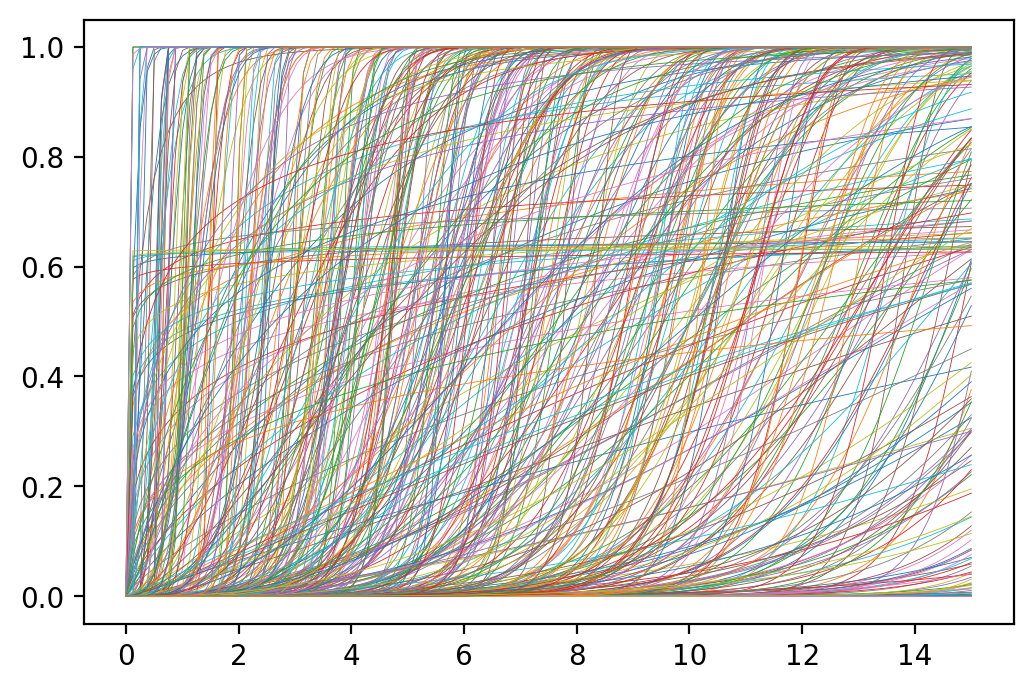

In [7]:
t = torch.linspace(0.0,15,120, device=trainer.device, dtype=torch.float32).unsqueeze(0)
plt.figure(dpi=200)
for i in range(K):
    if i % 10 != 0:
        pass
    w = torch.zeros((1,K), dtype=torch.float32, device=trainer.device)
    w[0,i] = 1000
    out = trainer.model.calculate_pdf(w, t)
    plt.plot(t.detach().cpu().numpy()[0], out.detach().cpu().numpy()[0], lw=0.3)
plt.show()
plt.close()

Here for each digit(0-9 which indicates the time.) we pick out 2 samples and illustrate the estimated survival function.

This figure shows the original image(left column), the estimated survival function(middle column), and the output of the network. 

In the middle column, the red dotted line represents $t_1$, the green dotted line represents $t_2$, and the orange line represent the ground truth time-to-event

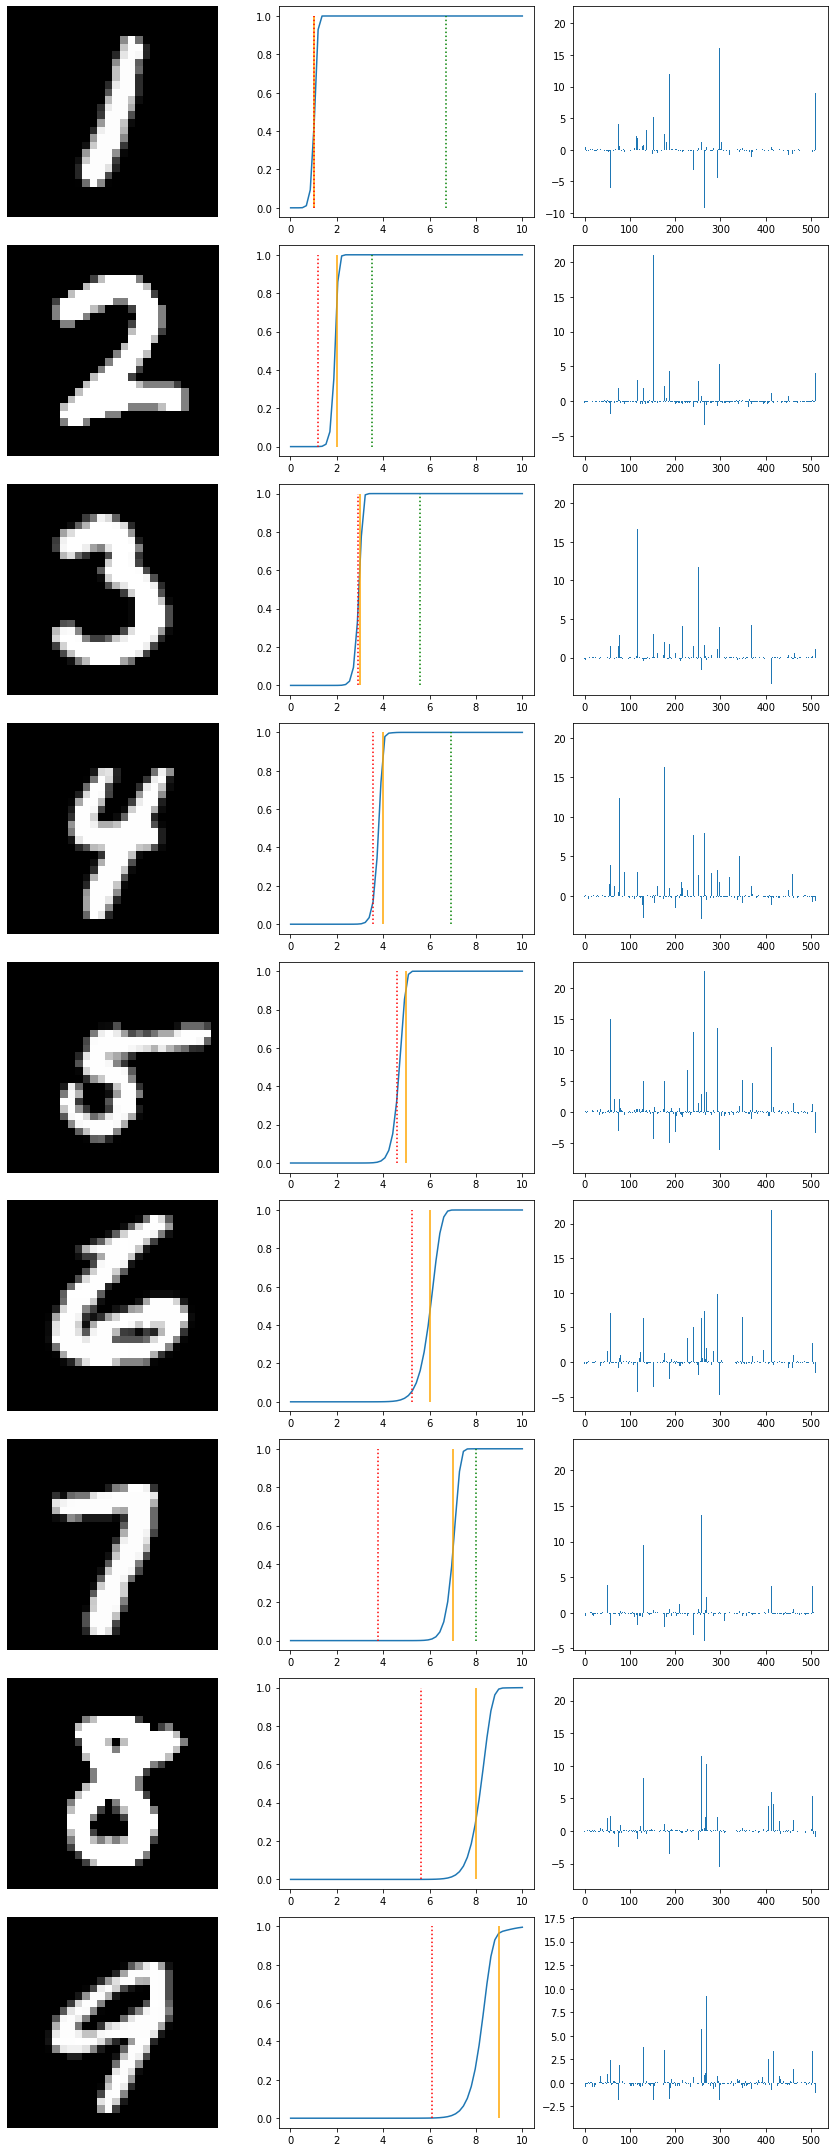

In [8]:
from collections import defaultdict


trainer.model.eval()
data = DummyData(testing=True)

inds = []
for i in range(1, 10):
    inds.extend(np.where(data.label==i)[0][-1:])
plt.figure(figsize=(12,30))

for i, index in enumerate(inds):
    
    index = int(index)
    img, t1, t2, e, l = data[index]
    img = img.unsqueeze(0).to(trainer.device)
    label = data.label[l]
    
    w = trainer.model(img)
    cdf = trainer.model.calculate_pdf(w, torch.FloatTensor(np.linspace(0.01,10,60)).unsqueeze(0).to(trainer.device))
    cdf=cdf.detach().cpu().numpy()
    # plt.figure(figsize=(9,3))
    plt.subplot(len(inds), 3, i*3 + 1)
    plt.imshow(img[0][0].cpu().numpy(), cmap='gray')
    # plt.colorbar()
    plt.axis('off')
    plt.subplot(len(inds), 3, i*3 + 2)
    plt.plot(np.linspace(0.01,10,60), cdf[0])
    plt.vlines(label, 0, 1, colors='orange')
    plt.vlines(t1, 0,1, color='r', linestyles='dotted')
    if t2 > t1:
        plt.vlines(t2, 0,1, color='g', linestyles='dotted')
    plt.subplot(len(inds), 3, i*3 + 3)
    plt.bar(x = np.array(range(K)), height= (w.detach().cpu()).numpy()[0], width=1)
plt.tight_layout()
plt.show()
plt.close()
    # print(t1, t2)